In [1]:
#export
import torch, numpy as np; from k1lib.cli import *
from typing import Callable, Union, Iterator
import matplotlib.pyplot as plt
__all__ = ["FunctionData", "tfImg", "tfFloat", "analyzeFloat"]

In [2]:
#export
class FunctionData:
    @staticmethod
    def main(f:Callable, bs:int=32, epochs:int=300):
        """Constructs 2 dataloaders, train and valid, for a particular function.
Example::

    trainDl, validDl = kdata.FunctionData.main(torch.exp, 32, 300)
    for epoch in range(3):
        for xb, yb in trainDl:
            model(xb)"""
        x = torch.linspace(-5, 5, 1000)
        ds = [x, f(x)] | transpose() | randomize(None)
        return ds | splitList(8, 2) | (repeatFrom() | randomize() | batched(32)\
            | (transpose() | toTensor()).all()).all()\
            | (stagger(epochs*.8) + stagger(epochs*.2)) | toList()
    @staticmethod
    def exp(bs, epochs): return FunctionData.main(torch.exp, bs, epochs)
    @staticmethod
    def log(bs, epochs): return FunctionData.main(torch.log, bs, epochs)
    @staticmethod
    def inverse(bs, epochs): return FunctionData.main(lambda x: 1/x, bs, epochs)
    @staticmethod
    def linear(bs, epochs): return FunctionData.main(lambda x: 2*x+8, bs, epochs)
    @staticmethod
    def sin(bs, epochs): return FunctionData.main(torch.sin, bs, epochs)

In [3]:
trainDl, validDl = FunctionData.main(torch.exp, 32, 300); inside = False
for epoch in range(3):
    for xb, yb in trainDl: inside = True; break
assert inside

In [4]:
#export
def tfImg(size:int=None, /, flip=True) -> BaseCli:
    """Get typical image transforms.
Example::

    "img path" | toPIL() | kdata.imgTf(224)"""
    import torchvision.transforms as tf
    op = identity()
    if size: op |= applyS(tf.Resize(size)) | applyS(tf.CenterCrop(size))
    op |= applyS(tf.ColorJitter(0.2, 0.2, 0.2)) | applyS(tf.RandomAffine(5))
    if flip: op |= applyS(tf.RandomHorizontalFlip())
    return op

In [5]:
#export
def tensorGuard(t, force:bool):
    if isinstance(t, np.ndarray): t = torch.tensor(t)
    if not isinstance(t, torch.Tensor): t = t | toFloat(force=force) | deref() | toTensor()
    return t
def tfFloat(t:Union[Iterator[float], torch.Tensor], force=True) -> BaseCli:
    """Suggested float input transformation function.
Example::

    # before training
    data = torch.randn(10, 20) * 100 + 20 # weird data with weird hist distribution
    f = kdata.tfFloat(data)

    # while training
    newData = torch.randn(10, 20) * 105 + 15
    newData | f # nicely formatted Tensor, going uniformly from -1 to 1

:param force: if True, forces weird values to 0.0, else filters out all weird rows."""
    t = tensorGuard(t, force); bounds = t.histBounds()
    return applyS(lambda t: tensorGuard(t, force).histScaled(0, bounds)*2 - 1)

In [6]:
data = torch.randn(10, 20) * 100 + 20 # weird data with weird hist distribution
newData = (torch.randn(10, 20) * 105 + 15) | tfFloat(data)
assert all((newData | (toMin() & toMax()) | toTensor()) - ([-1, 1] | toTensor()) < 0.1)

In [7]:
#export
@applyS
def analyzeFloat(l:Iterator[float]):
    """Preliminary input float stream analysis.
Example::

    torch.linspace(-2, 2, 50) | kdata.analyzeFloat"""
    l = l | deref(); lf = l | toFloat() | toTensor()
    nl = l | shape(0); nlf = len(lf)
    print(f"Percent of useful data: {nlf}/{nl} ({round(100*nlf/nl)}%)")
    print(f"- Mean: {lf.mean()}"); print(f"- Std: {lf.std()}")
    print(f"- Min: {lf.min()}");   print(f"- Max: {lf.max()}")
    plt.hist(lf.numpy(), bins=30); plt.title("Values histogram"); plt.ylabel("Frequency"); plt.show()
    plt.hist(lf.histScaled().numpy(), bins=30); plt.ylabel("Frequency"); plt.title("Scaled histogram")

Percent of useful data: 50/50 (100%)
- Mean: -3.33786012163273e-08
- Std: 1.1899901628494263
- Min: -2.0
- Max: 2.0


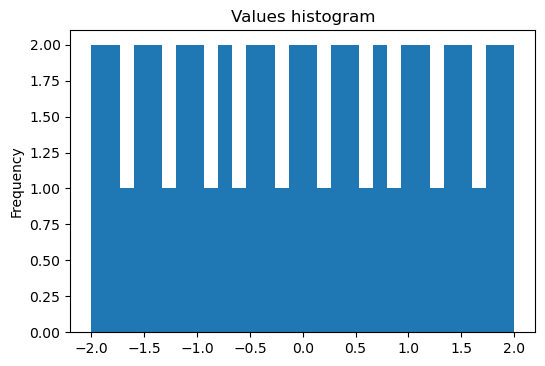

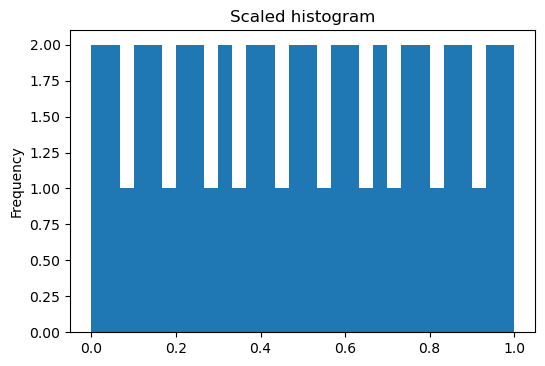

In [8]:
torch.linspace(-2, 2, 50) | analyzeFloat

In [9]:
!../export.py kdata

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.4
Uninstalling k1lib-0.4:
  Successfully uninstalled k1lib-0.4
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib/_baseClasses.py -> build/lib/k1lib
copying k1lib/_ba